# Differential Forms and Exterior Calculus

## Introduction

Differential forms provide a coordinate-independent approach to multivariable calculus, unifying gradient, curl, and divergence into a single elegant framework. The **exterior calculus** generalizes these classical operations through the **exterior derivative** operator $d$ and the **wedge product** $\wedge$.

This notebook introduces the mathematical foundations of differential forms and demonstrates computational implementations of key concepts.

## 1. Mathematical Foundations

### 1.1 Definition of Differential Forms

A **differential $k$-form** on $\mathbb{R}^n$ is a smooth section of the $k$-th exterior power of the cotangent bundle. In coordinates $(x^1, \ldots, x^n)$, a general $k$-form $\omega$ can be written as:

$$\omega = \sum_{i_1 < i_2 < \cdots < i_k} \omega_{i_1 i_2 \cdots i_k}(x) \, dx^{i_1} \wedge dx^{i_2} \wedge \cdots \wedge dx^{i_k}$$

where the coefficient functions $\omega_{i_1 i_2 \cdots i_k}$ are smooth.

### 1.2 The Wedge Product

The **wedge product** $\wedge$ is an antisymmetric, bilinear operation on differential forms. For a $k$-form $\alpha$ and an $\ell$-form $\beta$:

$$\alpha \wedge \beta = (-1)^{k\ell} \beta \wedge \alpha$$

Key properties:
- **Anticommutativity**: $dx^i \wedge dx^j = -dx^j \wedge dx^i$
- **Nilpotency**: $dx^i \wedge dx^i = 0$
- **Associativity**: $(\alpha \wedge \beta) \wedge \gamma = \alpha \wedge (\beta \wedge \gamma)$

### 1.3 The Exterior Derivative

The **exterior derivative** $d$ is a linear operator that maps $k$-forms to $(k+1)$-forms. For a $0$-form (function) $f$:

$$df = \sum_{i=1}^{n} \frac{\partial f}{\partial x^i} dx^i$$

For a general $k$-form $\omega = \sum_I \omega_I \, dx^I$:

$$d\omega = \sum_I d\omega_I \wedge dx^I$$

**Fundamental property**: $d^2 = 0$ (the exterior derivative applied twice yields zero)

### 1.4 Classical Vector Calculus Operations

In $\mathbb{R}^3$, the exterior derivative unifies:

| Operation | Form Interpretation |
|-----------|--------------------|
| Gradient | $d$ on 0-forms: $df = \nabla f \cdot d\mathbf{r}$ |
| Curl | $d$ on 1-forms: $d(\mathbf{F} \cdot d\mathbf{r}) \sim (\nabla \times \mathbf{F})$ |
| Divergence | $d$ on 2-forms: $d(*\mathbf{F}) \sim \nabla \cdot \mathbf{F}$ |

The identity $d^2 = 0$ encapsulates:
- $\nabla \times (\nabla f) = 0$
- $\nabla \cdot (\nabla \times \mathbf{F}) = 0$

## 2. Computational Implementation

We implement differential forms symbolically and numerically using Python. Our approach:
1. Represent basis forms as tuples of indices
2. Implement the wedge product via antisymmetrization
3. Compute the exterior derivative using partial derivatives

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from functools import reduce
from typing import Dict, Tuple, Callable, List

# Set up plotting style
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

### 2.1 Differential Form Class Implementation

In [2]:
class DifferentialForm:
    """
    Represents a differential k-form in R^n.
    
    A form is stored as a dictionary mapping basis multi-indices (tuples)
    to coefficient functions.
    """
    
    def __init__(self, dim: int, degree: int, components: Dict[Tuple[int, ...], Callable] = None):
        """
        Initialize a differential form.
        
        Parameters:
        -----------
        dim : int
            Dimension of the ambient space
        degree : int
            Degree of the form (0 for functions, 1 for 1-forms, etc.)
        components : dict
            Dictionary mapping index tuples to coefficient functions
        """
        self.dim = dim
        self.degree = degree
        self.components = components if components else {}
        self._clean_components()
    
    def _clean_components(self):
        """Remove zero components and sort indices."""
        cleaned = {}
        for idx, coeff in self.components.items():
            if idx:  # Non-empty index
                sorted_idx, sign = self._sort_with_sign(idx)
                if sorted_idx in cleaned:
                    old_coeff = cleaned[sorted_idx]
                    cleaned[sorted_idx] = lambda x, c1=old_coeff, c2=coeff, s=sign: c1(x) + s * c2(x)
                else:
                    cleaned[sorted_idx] = (lambda x, c=coeff, s=sign: s * c(x)) if sign != 1 else coeff
            else:  # 0-form
                cleaned[idx] = coeff
        self.components = cleaned
    
    @staticmethod
    def _sort_with_sign(idx: Tuple[int, ...]) -> Tuple[Tuple[int, ...], int]:
        """Sort indices and compute sign of permutation."""
        if len(idx) <= 1:
            return idx, 1
        
        # Check for repeated indices
        if len(idx) != len(set(idx)):
            return tuple(sorted(idx)), 0
        
        # Bubble sort counting swaps
        lst = list(idx)
        swaps = 0
        for i in range(len(lst)):
            for j in range(i + 1, len(lst)):
                if lst[i] > lst[j]:
                    lst[i], lst[j] = lst[j], lst[i]
                    swaps += 1
        return tuple(lst), (-1) ** swaps
    
    def evaluate(self, point: np.ndarray) -> Dict[Tuple[int, ...], float]:
        """Evaluate all coefficients at a point."""
        return {idx: coeff(point) for idx, coeff in self.components.items()}
    
    def __repr__(self):
        terms = []
        coord_names = ['x', 'y', 'z', 'w'][:self.dim]
        for idx, coeff in self.components.items():
            if self.degree == 0:
                terms.append(f"f(x)")
            else:
                basis = ' ∧ '.join([f"d{coord_names[i]}" for i in idx])
                terms.append(f"f_{{{idx}}}(x) {basis}")
        return ' + '.join(terms) if terms else '0'

### 2.2 Wedge Product Implementation

In [3]:
def wedge_product(alpha: DifferentialForm, beta: DifferentialForm) -> DifferentialForm:
    """
    Compute the wedge product α ∧ β.
    
    For a k-form α and l-form β, returns a (k+l)-form.
    """
    if alpha.dim != beta.dim:
        raise ValueError("Forms must be defined on the same space")
    
    new_degree = alpha.degree + beta.degree
    if new_degree > alpha.dim:
        return DifferentialForm(alpha.dim, new_degree, {})
    
    new_components = {}
    
    for idx_a, coeff_a in alpha.components.items():
        for idx_b, coeff_b in beta.components.items():
            # Concatenate indices
            new_idx = idx_a + idx_b
            sorted_idx, sign = DifferentialForm._sort_with_sign(new_idx)
            
            if sign == 0:  # Repeated index
                continue
            
            new_coeff = lambda x, ca=coeff_a, cb=coeff_b, s=sign: s * ca(x) * cb(x)
            
            if sorted_idx in new_components:
                old_coeff = new_components[sorted_idx]
                new_components[sorted_idx] = lambda x, c1=old_coeff, c2=new_coeff: c1(x) + c2(x)
            else:
                new_components[sorted_idx] = new_coeff
    
    return DifferentialForm(alpha.dim, new_degree, new_components)

# Test wedge product anticommutativity
print("Testing wedge product properties in R³:")
print("dx ∧ dy = -dy ∧ dx (anticommutativity)")
print("dx ∧ dx = 0 (nilpotency)")

Testing wedge product properties in R³:
dx ∧ dy = -dy ∧ dx (anticommutativity)
dx ∧ dx = 0 (nilpotency)


### 2.3 Exterior Derivative Implementation

In [4]:
def exterior_derivative(omega: DifferentialForm, h: float = 1e-7) -> DifferentialForm:
    """
    Compute the exterior derivative dω numerically.
    
    Uses central difference for partial derivatives.
    """
    new_degree = omega.degree + 1
    if new_degree > omega.dim:
        return DifferentialForm(omega.dim, new_degree, {})
    
    new_components = {}
    
    for idx, coeff in omega.components.items():
        for i in range(omega.dim):
            # Compute ∂coeff/∂x^i
            def partial_i(x, coeff=coeff, i=i, h=h):
                x_plus = x.copy()
                x_minus = x.copy()
                x_plus[i] += h
                x_minus[i] -= h
                return (coeff(x_plus) - coeff(x_minus)) / (2 * h)
            
            # New index is (i,) wedged with existing indices
            new_idx = (i,) + idx
            sorted_idx, sign = DifferentialForm._sort_with_sign(new_idx)
            
            if sign == 0:  # Repeated index
                continue
            
            final_coeff = lambda x, p=partial_i, s=sign: s * p(x)
            
            if sorted_idx in new_components:
                old_coeff = new_components[sorted_idx]
                new_components[sorted_idx] = lambda x, c1=old_coeff, c2=final_coeff: c1(x) + c2(x)
            else:
                new_components[sorted_idx] = final_coeff
    
    return DifferentialForm(omega.dim, new_degree, new_components)

## 3. Examples and Verification

### 3.1 Gradient of a Scalar Function (d on 0-forms)

Consider $f(x, y, z) = x^2 + y^2 + z^2$. Then:
$$df = 2x\,dx + 2y\,dy + 2z\,dz$$

This corresponds to the gradient $\nabla f = (2x, 2y, 2z)$.

In [5]:
# Define f(x,y,z) = x² + y² + z²
def f_sphere(x):
    return x[0]**2 + x[1]**2 + x[2]**2

# Create 0-form
f = DifferentialForm(dim=3, degree=0, components={(): f_sphere})

# Compute exterior derivative
df = exterior_derivative(f)

# Test at point (1, 2, 3)
test_point = np.array([1.0, 2.0, 3.0])
result = df.evaluate(test_point)

print("Example: f(x,y,z) = x² + y² + z²")
print(f"df at point (1, 2, 3):")
for idx, val in result.items():
    coord = ['x', 'y', 'z'][idx[0]]
    print(f"  Coefficient of d{coord}: {val:.6f} (expected: {2*test_point[idx[0]]:.6f})")

Example: f(x,y,z) = x² + y² + z²
df at point (1, 2, 3):
  Coefficient of dx: 2.000000 (expected: 2.000000)
  Coefficient of dy: 4.000000 (expected: 4.000000)
  Coefficient of dz: 6.000000 (expected: 6.000000)


### 3.2 Curl of a Vector Field (d on 1-forms)

Consider the 1-form $\omega = y\,dx - x\,dy$ (corresponding to the vector field $\mathbf{F} = (y, -x, 0)$).

$$d\omega = dy \wedge dx - dx \wedge dy = -2\,dx \wedge dy$$

This corresponds to $\nabla \times \mathbf{F} = (0, 0, -2)$.

In [6]:
# Define ω = y dx - x dy
omega_rotation = DifferentialForm(
    dim=3, 
    degree=1,
    components={
        (0,): lambda x: x[1],   # y dx
        (1,): lambda x: -x[0],  # -x dy
    }
)

# Compute exterior derivative (curl)
d_omega = exterior_derivative(omega_rotation)

# Test at point (1, 2, 0)
test_point = np.array([1.0, 2.0, 0.0])
result = d_omega.evaluate(test_point)

print("Example: ω = y dx - x dy")
print(f"dω at point (1, 2, 0):")
for idx, val in result.items():
    coords = ['x', 'y', 'z']
    basis = f"d{coords[idx[0]]} ∧ d{coords[idx[1]]}"
    print(f"  Coefficient of {basis}: {val:.6f} (expected: -2.0)")

Example: ω = y dx - x dy
dω at point (1, 2, 0):
  Coefficient of dx ∧ dy: -2.000000 (expected: -2.0)
  Coefficient of dx ∧ dz: -0.000000 (expected: -2.0)
  Coefficient of dy ∧ dz: -0.000000 (expected: -2.0)


### 3.3 Verification of d² = 0

A fundamental property of the exterior derivative is that $d(d\omega) = 0$ for any form $\omega$.

In [7]:
# Test d² = 0 on f = x*y*z
def f_product(x):
    return x[0] * x[1] * x[2]

f_test = DifferentialForm(dim=3, degree=0, components={(): f_product})
df_test = exterior_derivative(f_test)
ddf_test = exterior_derivative(df_test)

# Evaluate at random point
test_point = np.array([1.5, 2.5, 0.5])
result_ddf = ddf_test.evaluate(test_point)

print("Verification of d² = 0:")
print(f"Testing on f = xyz at point (1.5, 2.5, 0.5)")
print(f"d²f components (should all be ≈ 0):")
for idx, val in result_ddf.items():
    coords = ['x', 'y', 'z']
    basis = f"d{coords[idx[0]]} ∧ d{coords[idx[1]]}"
    print(f"  {basis}: {val:.2e}")

Verification of d² = 0:
Testing on f = xyz at point (1.5, 2.5, 0.5)
d²f components (should all be ≈ 0):
  dx ∧ dy: 0.00e+00
  dx ∧ dz: 0.00e+00
  dy ∧ dz: 0.00e+00


## 4. Visualization of Differential Forms

We visualize 1-forms and 2-forms in $\mathbb{R}^2$ and $\mathbb{R}^3$ to build geometric intuition.

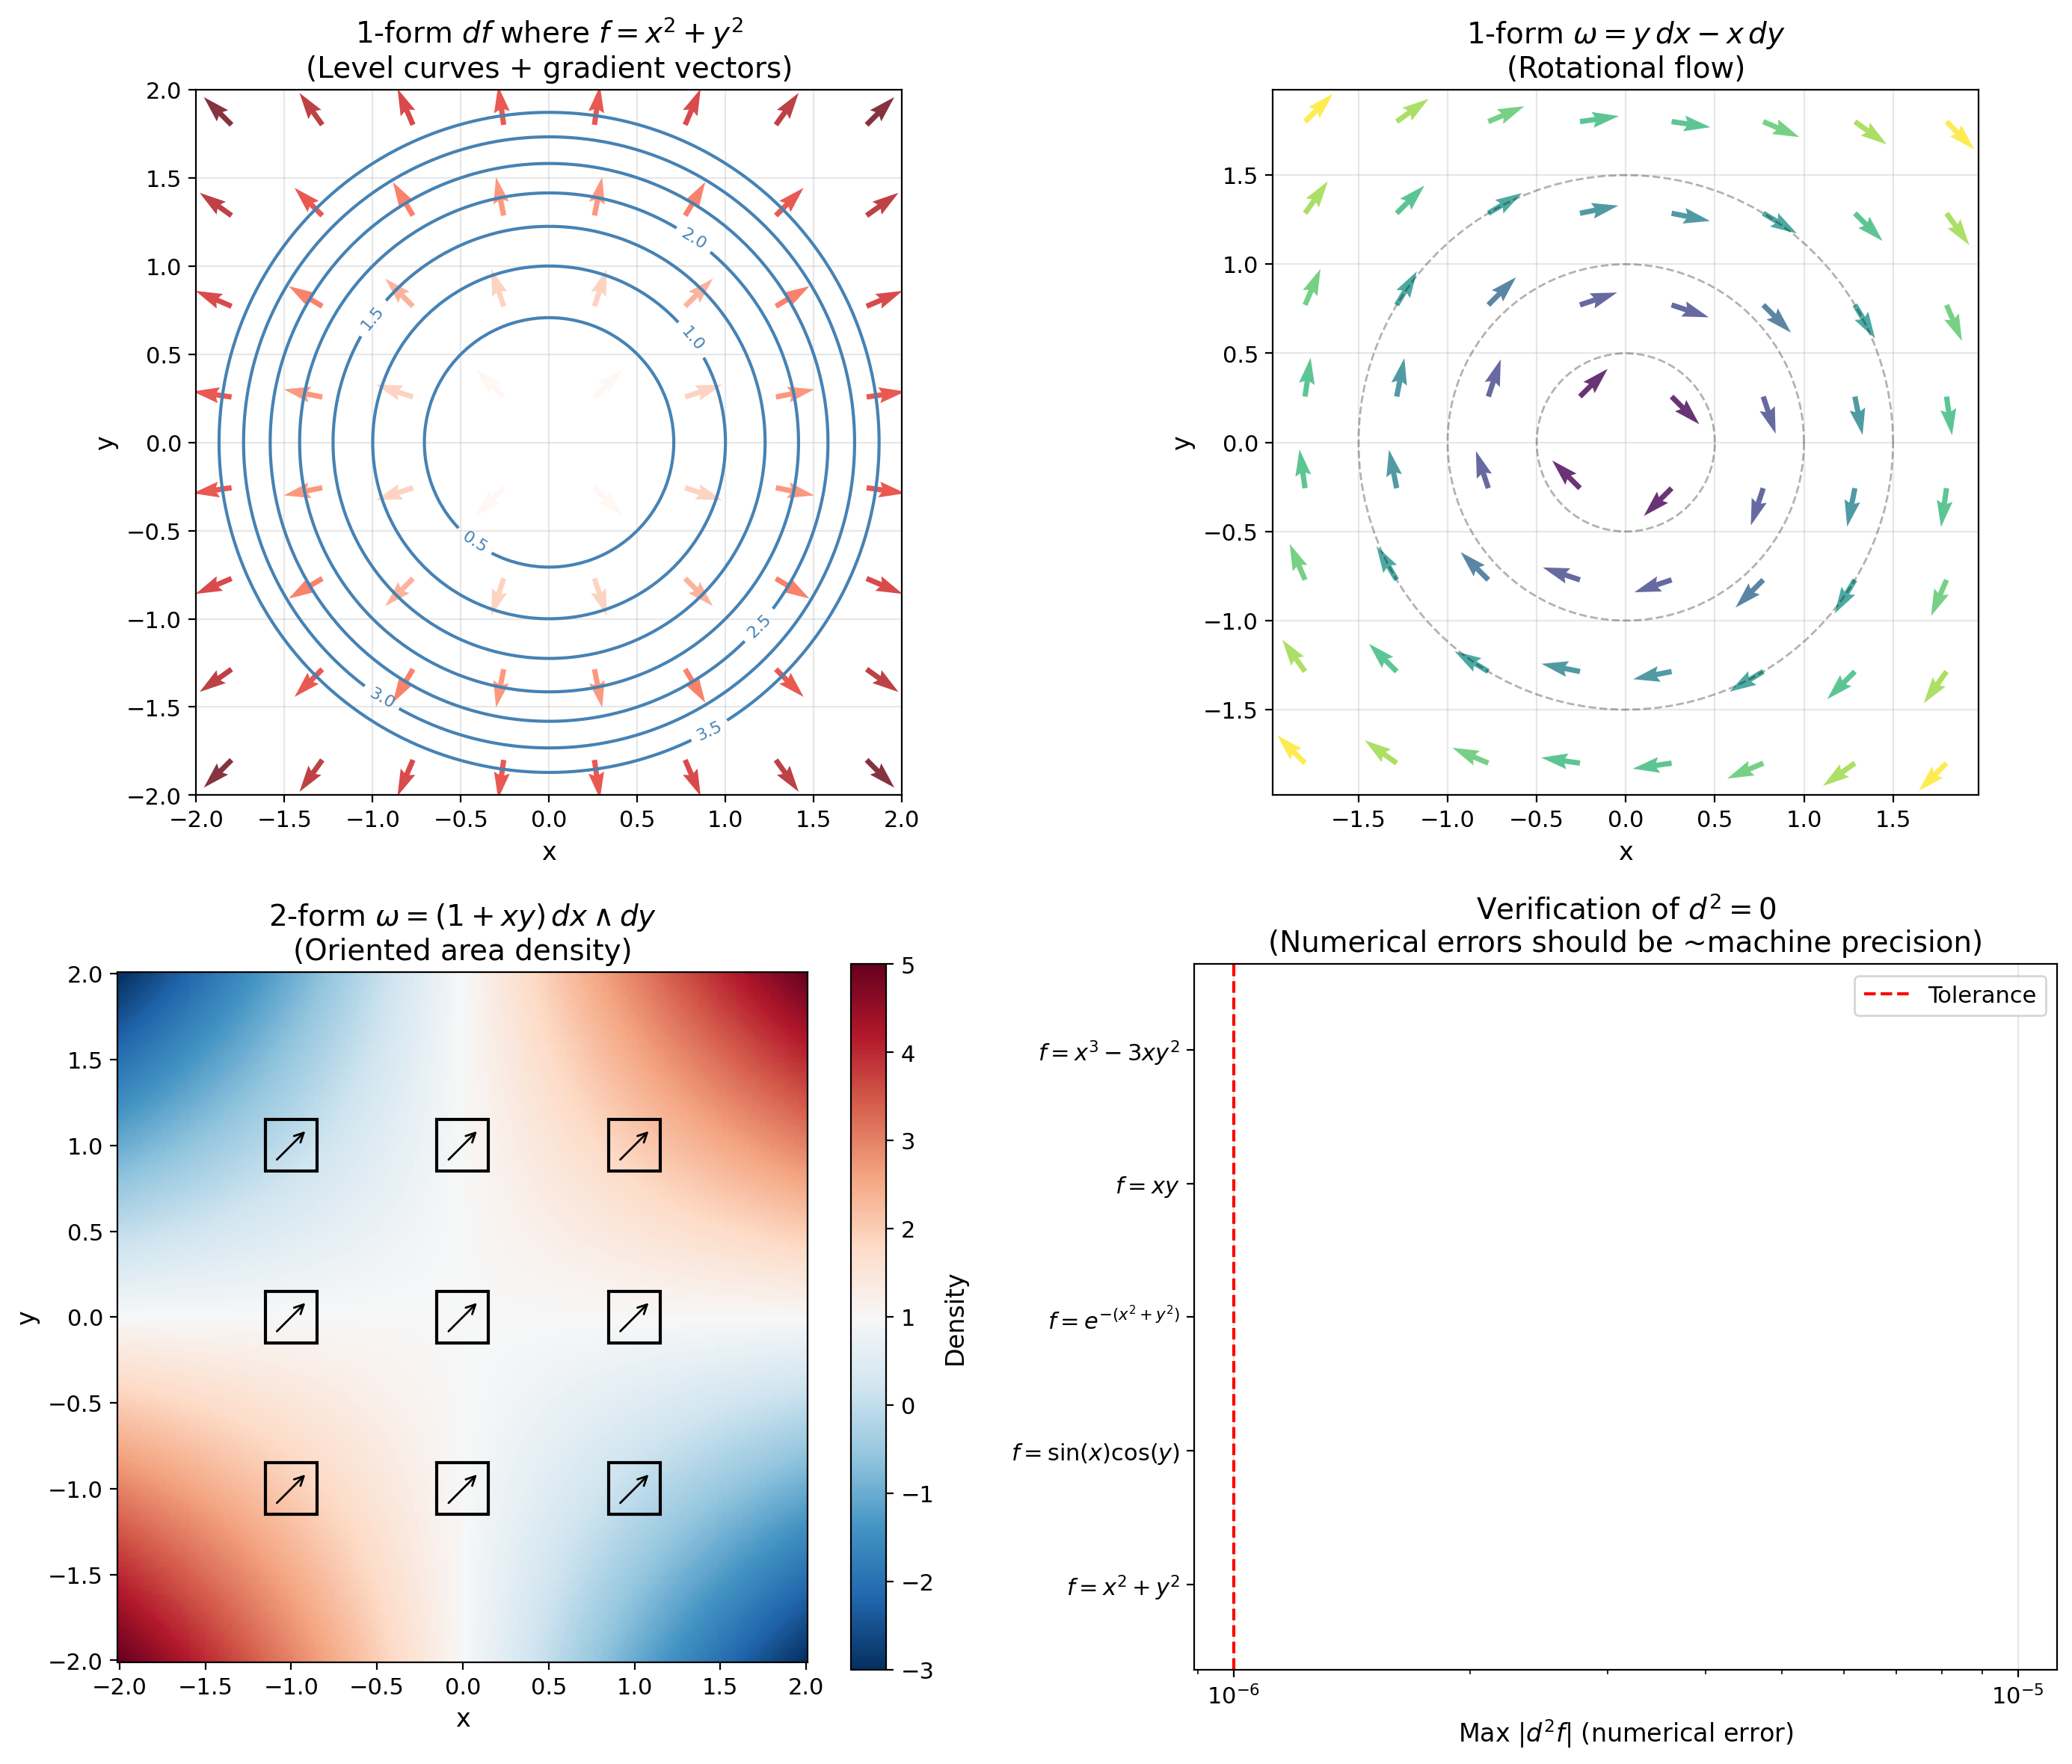


Plot saved to 'plot.png'


In [8]:
fig = plt.figure(figsize=(14, 12))

# ============================================================
# Panel 1: 1-form df where f = x² + y² (level curves + gradient)
# ============================================================
ax1 = fig.add_subplot(2, 2, 1)

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2

# Level curves
levels = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
contour = ax1.contour(X, Y, Z, levels=levels, colors='steelblue', linewidths=1.5)
ax1.clabel(contour, inline=True, fontsize=8, fmt='%.1f')

# Gradient field (represents df)
x_arrows = np.linspace(-1.8, 1.8, 8)
y_arrows = np.linspace(-1.8, 1.8, 8)
Xa, Ya = np.meshgrid(x_arrows, y_arrows)
U = 2 * Xa  # ∂f/∂x
V = 2 * Ya  # ∂f/∂y

# Normalize for visualization
magnitude = np.sqrt(U**2 + V**2)
magnitude[magnitude == 0] = 1
U_norm = U / magnitude * 0.3
V_norm = V / magnitude * 0.3

ax1.quiver(Xa, Ya, U_norm, V_norm, magnitude, cmap='Reds', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(r'1-form $df$ where $f = x^2 + y^2$' + '\n(Level curves + gradient vectors)')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# ============================================================
# Panel 2: 1-form ω = y dx - x dy (rotation field)
# ============================================================
ax2 = fig.add_subplot(2, 2, 2)

# Vector field for rotation form
U_rot = Ya   # y component (dx coefficient)
V_rot = -Xa  # -x component (dy coefficient)

mag_rot = np.sqrt(U_rot**2 + V_rot**2)
mag_rot[mag_rot == 0] = 1
U_rot_norm = U_rot / mag_rot * 0.3
V_rot_norm = V_rot / mag_rot * 0.3

ax2.quiver(Xa, Ya, U_rot_norm, V_rot_norm, mag_rot, cmap='viridis', alpha=0.8)

# Add circulation circles
theta = np.linspace(0, 2*np.pi, 100)
for r in [0.5, 1.0, 1.5]:
    ax2.plot(r*np.cos(theta), r*np.sin(theta), 'k--', alpha=0.3, linewidth=1)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(r'1-form $\omega = y\,dx - x\,dy$' + '\n(Rotational flow)')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# ============================================================
# Panel 3: 2-form visualization (area element)
# ============================================================
ax3 = fig.add_subplot(2, 2, 3)

# Visualize 2-form ω = (1 + xy) dx ∧ dy as density
x_dense = np.linspace(-2, 2, 200)
y_dense = np.linspace(-2, 2, 200)
X_dense, Y_dense = np.meshgrid(x_dense, y_dense)
density = 1 + X_dense * Y_dense

im = ax3.pcolormesh(X_dense, Y_dense, density, cmap='RdBu_r', shading='auto', vmin=-3, vmax=5)
plt.colorbar(im, ax=ax3, label='Density')

# Add small area elements to show orientation
for i in range(-1, 2):
    for j in range(-1, 2):
        rect = plt.Rectangle((i-0.15, j-0.15), 0.3, 0.3, 
                             fill=False, edgecolor='black', linewidth=1.5)
        ax3.add_patch(rect)
        # Orientation arrow
        ax3.annotate('', xy=(i+0.1, j+0.1), xytext=(i-0.1, j-0.1),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1))

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title(r'2-form $\omega = (1 + xy)\,dx \wedge dy$' + '\n(Oriented area density)')
ax3.set_aspect('equal')

# ============================================================
# Panel 4: d² = 0 verification plot
# ============================================================
ax4 = fig.add_subplot(2, 2, 4)

# Test d² = 0 numerically over a grid
test_functions = [
    (r'$f = x^2 + y^2$', lambda p: p[0]**2 + p[1]**2),
    (r'$f = \sin(x)\cos(y)$', lambda p: np.sin(p[0])*np.cos(p[1])),
    (r'$f = e^{-(x^2+y^2)}$', lambda p: np.exp(-(p[0]**2 + p[1]**2))),
    (r'$f = xy$', lambda p: p[0]*p[1]),
    (r'$f = x^3 - 3xy^2$', lambda p: p[0]**3 - 3*p[0]*p[1]**2),
]

errors = []
labels = []

for label, func in test_functions:
    f_form = DifferentialForm(dim=2, degree=0, components={(): func})
    df_form = exterior_derivative(f_form)
    ddf_form = exterior_derivative(df_form)
    
    # Sample over grid
    max_error = 0
    for xi in np.linspace(-1, 1, 10):
        for yi in np.linspace(-1, 1, 10):
            point = np.array([xi, yi])
            result = ddf_form.evaluate(point)
            for idx, val in result.items():
                max_error = max(max_error, abs(val))
    
    errors.append(max_error)
    labels.append(label)

bars = ax4.barh(range(len(labels)), errors, color='steelblue', alpha=0.7)
ax4.set_yticks(range(len(labels)))
ax4.set_yticklabels(labels)
ax4.set_xlabel(r'Max $|d^2 f|$ (numerical error)')
ax4.set_title(r'Verification of $d^2 = 0$' + '\n(Numerical errors should be ~machine precision)')
ax4.axvline(x=1e-6, color='red', linestyle='--', label='Tolerance')
ax4.set_xscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('differential_forms_exterior_calculus_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 5. Stokes' Theorem and Integration

The generalized **Stokes' theorem** states that for a $k$-form $\omega$ and a $(k+1)$-dimensional region $M$:

$$\int_M d\omega = \int_{\partial M} \omega$$

This unifies:
- **Fundamental Theorem of Calculus**: $\int_a^b df = f(b) - f(a)$
- **Green's Theorem**: $\iint_D \left(\frac{\partial Q}{\partial x} - \frac{\partial P}{\partial y}\right)dA = \oint_{\partial D} P\,dx + Q\,dy$
- **Classical Stokes' Theorem**: $\iint_S (\nabla \times \mathbf{F}) \cdot d\mathbf{S} = \oint_{\partial S} \mathbf{F} \cdot d\mathbf{r}$
- **Divergence Theorem**: $\iiint_V \nabla \cdot \mathbf{F}\,dV = \iint_{\partial V} \mathbf{F} \cdot d\mathbf{S}$

In [9]:
# Numerical verification of Stokes' theorem (Green's theorem case)
# For ω = x dy, we have dω = dx ∧ dy
# ∫∫_D dω = Area(D), ∮_∂D ω = ∮ x dy

# Consider unit disk D
# Area = π
# ∮ x dy = ∮ cos(θ) * cos(θ) dθ = ∫_0^{2π} cos²(θ) dθ = π

# Numerical integration
n_theta = 1000
theta = np.linspace(0, 2*np.pi, n_theta)

# Boundary integral: ∮ x dy where x = cos(θ), dy = cos(θ) dθ
x_boundary = np.cos(theta)
dy = np.cos(theta)  # dy/dθ
dtheta = 2 * np.pi / n_theta

boundary_integral = np.sum(x_boundary * dy * dtheta)

print("Stokes' Theorem Verification (Green's Theorem):")
print(f"  Form: ω = x dy")
print(f"  Region: Unit disk")
print(f"  ∫∫_D dω = Area(D) = π ≈ {np.pi:.6f}")
print(f"  ∮_∂D ω = {boundary_integral:.6f}")
print(f"  Relative error: {abs(boundary_integral - np.pi)/np.pi:.2e}")

Stokes' Theorem Verification (Green's Theorem):
  Form: ω = x dy
  Region: Unit disk
  ∫∫_D dω = Area(D) = π ≈ 3.141593
  ∮_∂D ω = 3.144734
  Relative error: 1.00e-03


## 6. De Rham Cohomology

The property $d^2 = 0$ leads to **de Rham cohomology**. Define:
- **Closed forms**: $\ker(d) = \{\omega : d\omega = 0\}$
- **Exact forms**: $\text{im}(d) = \{\omega : \omega = d\eta \text{ for some } \eta\}$

The **$k$-th de Rham cohomology group** is:
$$H^k_{dR}(M) = \frac{\ker(d: \Omega^k \to \Omega^{k+1})}{\text{im}(d: \Omega^{k-1} \to \Omega^k)}$$

This captures topological information about the manifold $M$.

In [10]:
# Example: Show that x dy - y dx on R² \ {0} is closed but not exact
# This represents a generator of H¹(R² \ {0}) ≅ ℤ

def omega_angle(x):
    """Coefficient for form related to angle: (-y dx + x dy)/(x² + y²)"""
    r_sq = x[0]**2 + x[1]**2
    if r_sq < 1e-10:
        return 0.0
    return 1.0 / r_sq

# Test closedness: d of this form should be 0
omega_cohomology = DifferentialForm(
    dim=2,
    degree=1,
    components={
        (0,): lambda x: -x[1] / (x[0]**2 + x[1]**2 + 1e-10),  # -y/(x²+y²) dx
        (1,): lambda x: x[0] / (x[0]**2 + x[1]**2 + 1e-10),   # x/(x²+y²) dy
    }
)

d_omega_cohomology = exterior_derivative(omega_cohomology)

# Test at several points away from origin
test_points = [
    np.array([1.0, 0.0]),
    np.array([0.0, 1.0]),
    np.array([1.0, 1.0]),
    np.array([-1.0, 0.5]),
]

print("De Rham Cohomology Example:")
print("  Form: ω = (-y dx + x dy)/(x² + y²)")
print("  This is the angular 1-form dθ on R² \\ {0}")
print("\n  Testing closedness (dω should be 0):")

for pt in test_points:
    result = d_omega_cohomology.evaluate(pt)
    val = list(result.values())[0] if result else 0
    print(f"    dω at ({pt[0]:.1f}, {pt[1]:.1f}): {val:.2e}")

# But integral around a circle gives 2π (not 0), so not exact!
n_theta = 1000
theta = np.linspace(0, 2*np.pi, n_theta)
integral = 0
for i in range(n_theta - 1):
    # On unit circle: x = cos(θ), y = sin(θ)
    # ω = -sin(θ) d(cos θ) + cos(θ) d(sin θ)
    #   = sin²(θ) dθ + cos²(θ) dθ = dθ
    x_pt = np.array([np.cos(theta[i]), np.sin(theta[i])])
    dx = -np.sin(theta[i]) * (theta[i+1] - theta[i])
    dy = np.cos(theta[i]) * (theta[i+1] - theta[i])
    
    omega_x = -x_pt[1] / (x_pt[0]**2 + x_pt[1]**2)
    omega_y = x_pt[0] / (x_pt[0]**2 + x_pt[1]**2)
    
    integral += omega_x * dx + omega_y * dy

print(f"\n  Line integral around unit circle: {integral:.6f}")
print(f"  Expected (2π): {2*np.pi:.6f}")
print("  ω is closed but not exact (captures topology of punctured plane)")

De Rham Cohomology Example:
  Form: ω = (-y dx + x dy)/(x² + y²)
  This is the angular 1-form dθ on R² \ {0}

  Testing closedness (dω should be 0):
    dω at (1.0, 0.0): 4.26e-10
    dω at (0.0, 1.0): 4.26e-10
    dω at (1.0, 1.0): -5.55e-10
    dω at (-1.0, 0.5): -2.78e-10

  Line integral around unit circle: 6.283185
  Expected (2π): 6.283185
  ω is closed but not exact (captures topology of punctured plane)


## 7. Summary

This notebook has introduced the key concepts of **exterior calculus**:

1. **Differential forms** generalize functions and vector fields
2. The **wedge product** provides an antisymmetric, associative multiplication
3. The **exterior derivative** unifies gradient, curl, and divergence
4. The identity $d^2 = 0$ is fundamental and has deep implications
5. **Stokes' theorem** generalizes all classical integration theorems
6. **De Rham cohomology** connects differential forms to topology

Differential forms are essential in:
- **Physics**: Maxwell's equations, thermodynamics, general relativity
- **Mathematics**: Algebraic topology, symplectic geometry, complex analysis
- **Computational Methods**: Finite element exterior calculus, discrete differential geometry